___

**project**: `Heart Beat Sound Classification (HBSC) and Clustering`

**date**: `2025-06-27`

**main**: `Audio Processing (AP) pytorch`
____


In this notebook i will create a simple audio classification using `pytorch` and `torchaudio` to do heatbeat classification between `4` different categories of heart beat sound which are:

1. `artifact`
2. `extrahls`
3. `murmur`
4. `normal`

We are going to use the `SpectralClustering` to do audio clustering using the features that was learned from `M5` achitecture.

### Data
The dataset that we going to use in this notebook we be comming from [kaggle](https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds). We are going to use the data that is in the subfolder called `set_a`.

### Model Architecture

The model achitecture that i will be using in this notebook is called the `M5` for audio classification with `Convulutional Neural Networks(CNN)`.

### Installing Helper Packages
In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

In [1]:
pip install helperfns kaggle pigmenta -q

### Installation of torchaudio, librosa and boto3
We are going to use `torchadio` for this task, so we need to run the following code cell to install all the packages that we will need in this notebook.

In [2]:
!pip install -q torchaudio librosa boto3

#### Imports

In  the following code cell we are going to import all the packages that we are going to use throughout this `notebook`

In [3]:
import time
import json
import torch
import os
import random
import torchaudio
import warnings

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from torch import nn
import seaborn as sns
from helperfns.tables import tabulate_data
from helperfns.visualization import (
    plot_complicated_confusion_matrix, plot_simple_confusion_matrix, plot_classification_report
)
from helperfns.utils import hms_string
from IPython.display import Audio, display
from matplotlib import pyplot as plt
from pigmenta import PALETTES

import torch.nn.functional as F
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
print("torch: ", torch.__version__)
print("torchaudio: ", torchaudio.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.6.0+cu124
torchaudio:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [5]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

Our dataset that we are going to use will be comming from [`kaggle`](https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds). So we are going to download it using the `kaggle` api, in the code cells that follows.

> URL: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds

In [6]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

!kaggle datasets download kinguistics/heartbeat-sounds --unzip

Dataset URL: https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds
License(s): CC0-1.0
 62% 68.0M/110M [00:00<00:00, 674MB/s]
100% 110M/110M [00:00<00:00, 664MB/s] 


### Understanding the Structure of our Data.

First we need to read the `set_a.csv` file and understand how our data looks. So in the following code cell we are going to read the `set_a.csv` file in a dataframe.

In [7]:
df = pd.read_csv('set_a.csv')
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


So in this dataset we are intrested in two colums which are `fname` as well as `label`. Let's go ahead and check how many unique labels do we have in this dataset.

In [8]:
df.label.unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

We have `5` different labels including the `nan` which we are going to drop using the `dropna` function so that we will have filenames with the difined labels

In [9]:
df.dropna(inplace=True, subset=['label'])

In the next code cell we are then going to visualize the label's distribution in the dataset.

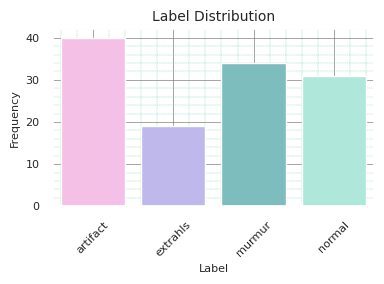

In [10]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=df, x="label", palette=PALETTES.rainbow[10:])
plt.xlabel("Label", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=45)
plt.title("Label Distribution", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

Getting classes

In [11]:
classes = df.label.unique()
classes

array(['artifact', 'extrahls', 'murmur', 'normal'], dtype=object)

### Helper functions
`load_audio`

This function takes in a path of the `.wav` file and load them using the `touchaudio.load()` function which returns the waveform in a torch tensor and a sample rate.

`load_data`

This helper function will takes in all the paths where the audios are located and the classnames of the audios and load all the audio and give them labels. It returns a list of list where each list contains `waveform`, `sample_rate`, `class_name`, `class_index`.

In [12]:
def load_audio(path:str):
  waveform, sample_rate = torchaudio.load(path)
  return waveform, sample_rate

def load_data(paths, classnames):
  data = list()
  for audio_path, class_name in zip(paths, classnames):
    waveform, sample_rate = load_audio(audio_path)
    data.append([waveform, sample_rate, class_name, list(classes).index(class_name)])
  return data

Getting file paths and class names.

In [13]:
paths = df.fname.values
classnames = df.label.values
assert len(paths) == len(classnames), "Lenth of paths and class names must be equal."

Generating the dataset from our `csv` file.

In [14]:
data = load_data(paths, classnames)

Checking as single example in our dataset.

In [15]:
data[0]

[tensor([[ 3.0518e-05, -9.1553e-05, -3.0518e-05,  ...,  0.0000e+00,
           3.0518e-05,  0.0000e+00]]),
 44100,
 'artifact',
 0]

### Splitting sets.

Since our dataset is very small and contains less examples we are going to split it into different sets which are `train` and `test/validation`. We are goin to use `100%` examples in the training and for our test data we are going to take `40%` from the whole dataset.


In [16]:
random.shuffle(data)

In [17]:
test_data = data[int(.4 * len(data)): ]
train_data = data

Counting examples.

In [18]:
columns = ["Set", "Example(s)"]

examples = [
    ['training', len(train_data)],
    ['testing', len(test_data)],
    ['total', len(train_data) +  len(test_data)],
]

tabulate_data(columns, examples, "Exmples")

Exmples
+----------+------------+
| Set      | Example(s) |
+----------+------------+
| training |        124 |
| testing  |         75 |
| total    |        199 |
+----------+------------+


### Visualizing examples
In the code cells that follows we are going to visualize examples that we have in our sets.

### Helper function play_audio()
`play_audio` takes in the waveform and the `sample_rate` as arguments and display an inline audio player in `ipynb`.

In [19]:
def play_audio(example):
  waveform, sample_rate, label, label_id = example
  print("Shape of waveform: {}".format(waveform.size()))
  print("Sample rate of waveform: {}".format(sample_rate))
  print("Label ID: {}".format(label))
  print("Label : {}".format(label_id))
  waveform = waveform.numpy()
  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

### Plotting a waveform
> Note that we can plot a waveform and see how waves are distributed in an audio.

In [20]:
def plot_wave_form(example):
  waveform, sample_rate, label, label_id = example
  print("Shape of waveform: {}".format(waveform.size()))
  print("Sample rate of waveform: {}".format(sample_rate))
  print("Label ID: {}".format(label))
  print("Label : {}".format(label_id))
  plt.plot(waveform.t().numpy())
  plt.show()

Shape of waveform: torch.Size([1, 396900])
Sample rate of waveform: 44100
Label ID: artifact
Label : 0


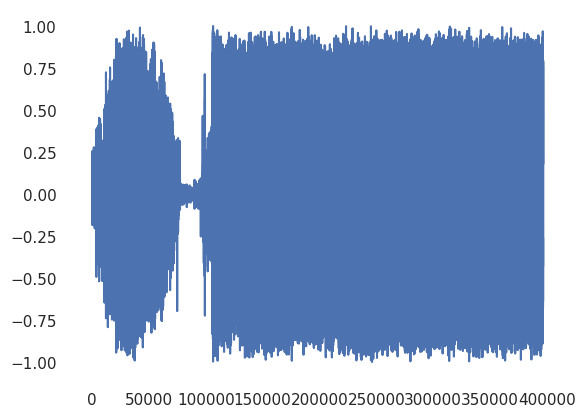

Shape of waveform: torch.Size([1, 396900])
Sample rate of waveform: 44100
Label ID: artifact
Label : 0


In [21]:
plot_wave_form(train_data[0])
play_audio(train_data[0])

Shape of waveform: torch.Size([1, 349958])
Sample rate of waveform: 44100
Label ID: murmur
Label : 2


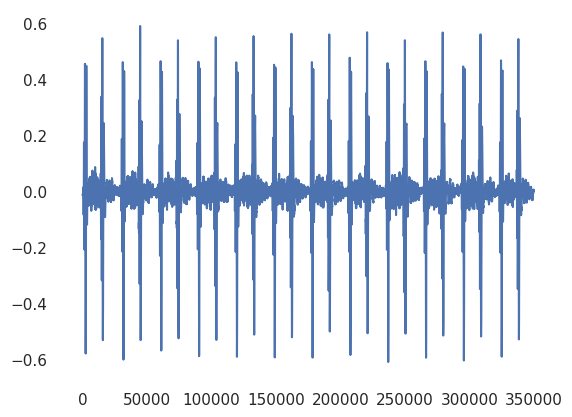

Shape of waveform: torch.Size([1, 349958])
Sample rate of waveform: 44100
Label ID: murmur
Label : 2


In [22]:
plot_wave_form(test_data[-1])
play_audio(test_data[-1])

### Downsampling the audio
Most of Our audios has a sample rate of `44100`, which is very huge and it is not effient to train the network on such a sample rate. We can downsample the sample rate so that we will be using the `touchaudio.transforms.Resample` method and change the sample rate to `8000`.

In [23]:
waveform, sample_rate, _, __  = train_data[0]

In [24]:
new_sample_rate = 8000
resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate,
                                           new_freq=new_sample_rate)
transformed = resample_transform(waveform)
# playing the original sound
play_audio(train_data[0])

Shape of waveform: torch.Size([1, 396900])
Sample rate of waveform: 44100
Label ID: artifact
Label : 0


Playing transformed audio

In [25]:
play_audio([transformed, new_sample_rate, 'artifact', 0] )

Shape of waveform: torch.Size([1, 72000])
Sample rate of waveform: 8000
Label ID: artifact
Label : 0


### Creating a dataset
We are going to create a dataset using the Dataset class from `torch.utils.data` we are going to call our dataset `HeartBeatSoundDataset`, This dataset class will take in data, and transform as it's argument.

1. data
* this is essentially a list of loaded data. example is `train_data`
2. transform
* these are transforms that we are going to apply on our features and labels.

In [26]:
class HeartBeatSoundDataset:
  def __init__(self, data, transform=None):
    self.data = data
    self.len = len(data)
    self.x = [i[0].numpy() for i in self.data]
    self.y = [i[-1] for i in self.data]
    self.transform = transform

  def __getitem__(self, index):
    sample = self.x[index], self.y[index]

    if self.transform:
        sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

### Transform
We are going to create a `ToTensor` custom transform that will convert features and `labels` to `tensors`.

In [27]:
class ToTensor:
  def __call__(self, samples):
    x, y = samples
    return torch.from_numpy(x.astype('float32')) ,torch.from_numpy(np.array(y))

Now we can be able to create our train and test data using the `HeartBeatSoundDataset` dataset.

In [28]:
train = HeartBeatSoundDataset(data=train_data, transform=ToTensor())
test  = HeartBeatSoundDataset(data=test_data, transform=ToTensor())

### Creating loaders
We are then going to create two loaders, the `train` and the `test` loaders for each set. Each loader will have a `collate_fn` which is more like a preprocessing function that is applied to the data by the `DataLoader` class from `torch.utils.data`

1. `pad_sequence`
* The audio's that we are working with are of different length, so we need to use the `pad_sequences` from `torch.nn.utils.rnn` so that we make sure that short audios are padded with `0's`. in the `torch.nn.utils.rnn.pad_sequences` function we are going to set `batch_first` to true, this is because we are going to use `Conv1` layers and Conv layers expect the `batch_size` to be first.
2. `collate_fn`

* In this function we are going to `transform` our audio waveforms and then apply the `pad_sequence` function.

In [29]:
def pad_sequence(batch):
  batch = [item.t() for item in batch]
  batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
  return batch.permute(0, 2, 1)

def collate_fn(batch):
  tensors, targets = [], []
  for waveform, label in batch:
    # apply the transformations, by downsampling the wavefor from sample_rate 8000
    tensors += [resample_transform(waveform)]
    targets += [label]
  tensors = pad_sequence(tensors)
  targets = torch.stack(targets)
  return tensors, targets

We are going to use the `batch_size` of 8 since our dataset is small.

In [30]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

Checking a single example in a batch.

In [31]:
next(iter(train_loader))

(tensor([[[ 0.0005,  0.0012,  0.0009,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0019, -0.0121, -0.0139,  ...,  0.0353,  0.0695, -0.0005]],
 
         [[-0.0027, -0.0048, -0.0011,  ...,  0.0010, -0.0009,  0.0014]],
 
         ...,
 
         [[-0.0246, -0.0467, -0.0410,  ..., -0.0019, -0.0014, -0.0017]],
 
         [[ 0.0301,  0.0514,  0.0452,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0047, -0.0069, -0.0045,  ...,  0.0039,  0.0038,  0.0031]]]),
 tensor([3, 0, 3, 2, 0, 0, 2, 1]))

### Creating a Model (M5)
We are going to use a Convolutional neural network to process the raw audio data. Usually more advanced transforms are applied to the audio data, however CNNs can be used to accurately process the raw data. The specific architecture is modeled after the `M5` network architecture.

In [32]:
class M5(nn.Module):
  def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, n_features=10):
    super(M5, self).__init__()
    self.conv_a = nn.Sequential(
        nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
        nn.BatchNorm1d(n_channel),
        nn.ReLU(),
        nn.MaxPool1d(4),
    )
    self.conv_b = nn.Sequential(
        nn.Conv1d(n_channel, n_channel, kernel_size=3),
        nn.BatchNorm1d(n_channel),
        nn.ReLU(),
        nn.MaxPool1d(4)
    )
    self.conv_c = nn.Sequential(
        nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3),
        nn.BatchNorm1d(2 * n_channel),
        nn.ReLU(),
        nn.MaxPool1d(4)
    )
    self.conv_d = nn.Sequential(
        nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3),
        nn.BatchNorm1d(2 * n_channel),
        nn.ReLU(),
        nn.MaxPool1d(4)
    )
    self.features = nn.Sequential( nn.Linear(2 * n_channel, n_features))
    self.out = nn.Sequential(nn.Linear(2 * n_channel, n_output))
  def forward(self, x):
    x = self.conv_a(x)
    x = self.conv_b(x)
    x = self.conv_c(x)
    x = self.conv_d(x)
    x = F.avg_pool1d(x, x.shape[-1])
    x = x.permute(0, 2, 1)
    return self.features(x), self.out(x)

In the following code cell we are going to create the instance of our model.

In [33]:
n_input = transformed.shape[0]
n_output = 1 if len(classes) == 2 else len(classes)
n_features = 10
hbsc_model = M5(
    n_input = n_input,
    n_output = n_output,
    n_features = n_features
).to(device)
hbsc_model

M5(
  (conv_a): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_b): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_c): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_d): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Re

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [34]:

def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["hbsc_model", *count_trainable_params(hbsc_model)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+------------+--------------+------------------+
| MODEL      | TOTAL PARAMS | TRAINABLE PARAMS |
+------------+--------------+------------------+
| hbsc_model |       25,550 |           25,550 |
+------------+--------------+------------------+


### Optimizer and Criterion

In the following code cell we are going to define the `optimizer` and `criterion`. For the `optimizer` we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `CrossEntropyLoss()` function since this is a `multi-class` classification.

In [35]:
optimizer = torch.optim.Adam(hbsc_model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the predicted labels and real labels.

In [36]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [37]:
def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for X, y in iterator:
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    _, predictions = model(X)
    predictions = predictions.squeeze()
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for X, y in iterator:
      X = X.to(device)
      y = y.to(device)
      _, predictions = model(X)
      predictions = predictions.squeeze()
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Training Loop.
When training the model we are going to train each model surperately. And we are also going to keep on tracking the training history of each model. The following `History` class is a data structure for our training history.

In [38]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, ett:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(ett)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [39]:
N_EPOCHS = 200
MODEL_NAME = 'hbsc-model.pt'

def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETT"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

history, ett, last_saved_epoch = run_train_loop(
    hbsc_model, MODEL_NAME, train_loader, test_loader, N_EPOCHS, optimizer, criterion
)

EPOCH: 01/200 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 1.201 |    0.383 | 0:00:02.30 |
| Validation | 1.381 |    0.300 |            |
+------------+-------+----------+------------+
EPOCH: 02/200 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.991 |    0.555 | 0:00:01.20 |
| Validation | 1.192 |    0.458 |            |
+------------+-------+----------+------------+
EPOCH: 03/200 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETT |
+------------+-------+----------+------------+
| Training   | 0.988 |    0.562 | 0:00:01.11 |
| Validation | 1.041 |    0.579 |            |
+------------+-------+----------+------------+
EPOCH: 04/200 saving best model...
+------------+

In the following code cell we are going to visualize the model's training history and last saved epoch.

In [40]:
rows = [
      ["hbsc_model", f'{N_EPOCHS}', f'{last_saved_epoch}', f'{hms_string(ett)}']
]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH")

CNN MODELS' TOTAL TRAINING TIME AND LAST SAVED EPOCH
+------------+--------------+------------------+-------------------------+
| MODEL      | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+------------+--------------+------------------+-------------------------+
| hbsc_model |          200 |              194 |              0:02:11.02 |
+------------+--------------+------------------+-------------------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

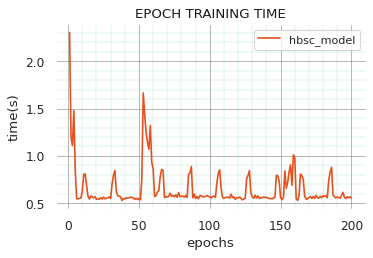

In [41]:
epochs = np.arange(1, N_EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.gold[1], label='hbsc_model')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for the model that was observed during model training.

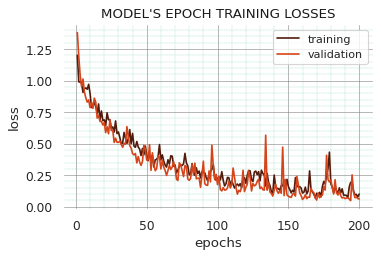

In [42]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.fall[0], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.fall[1], label='validation')
plt.title("MODEL'S EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

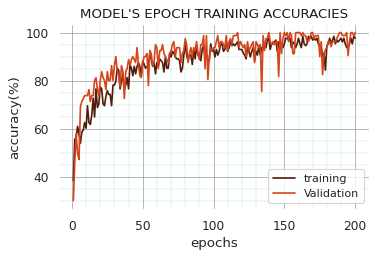

In [43]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.fall[0], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.fall[1], label='Validation')

plt.title("MODEL'S EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [44]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
hbsc_model.load_state_dict(torch.load(MODEL_NAME))
test_loss, test_acc = evaluate(hbsc_model, test_loader, criterion)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.048 |  100.00% |            |
+------+-------+----------+------------+


### Confusion Matrix

In the following code cell we are going to plot the confusion matrix based on the `test` data.

In [45]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  features = []
  with torch.no_grad():
    for (X, y) in iterator:
      X = X.to(device)
      _features, y_pred = model(X)
      probabilities = torch.softmax(y_pred.squeeze(), dim=0)
      prediction = torch.argmax(probabilities, dim=1).cpu()
      labels.append(y.cpu())
      predictions.append(prediction)
      features.append(_features.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  features = torch.cat(features, dim = 0).cpu().numpy()
  return labels, predictions, features.squeeze()

y_true, y_preds, features= get_predictions(hbsc_model, test_loader, device)

### Confusion matrix
In the following code cell we are going to plot the Confusion Matrix of our model.

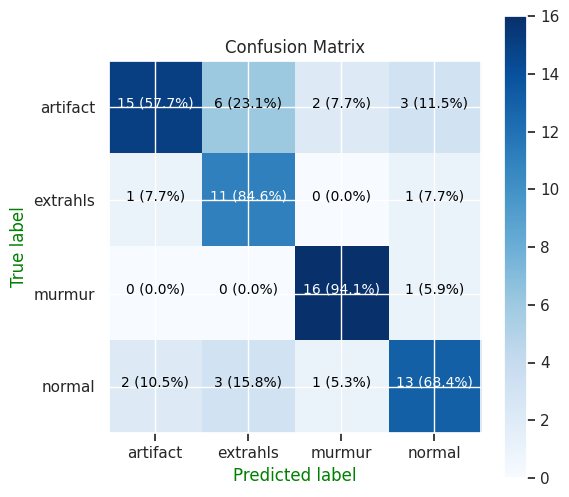

In [46]:
plot_complicated_confusion_matrix(y_true, y_preds, classes, (6, 6), 10)

### Classification report.
In the code cell that follows we are going to print the classification report based on the test data.

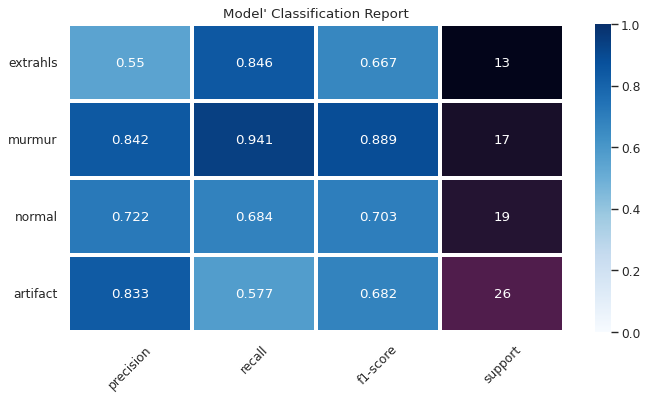

In [47]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Model\' Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = classes
)

In the next code cell we are going to use the `SpectralClustering` to cluster the heart beat sounds into 4 different clusters.

In [48]:
N_CLUSTERS = 4
spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors',
                              assign_labels='kmeans', random_state=SEED)
spectral_labels = spectral.fit_predict(features)

In the following code cell we are then going to evaluate the `SpectralClustering` on these heart beat sounds using different clustering metrics.

In [49]:
def evaluate_algorithms(algorithm, X, predicted_labels, true_labels=None):
  metrics = {
    "Silhouette Score": float(silhouette_score(X, predicted_labels)),
    "Davies-Bouldin Index": float(davies_bouldin_score(X, predicted_labels)),
    "Calinski-Harabasz Index": float(calinski_harabasz_score(X, predicted_labels))
  }
  if true_labels is not None:
    metrics["Mutual Info Score"] = mutual_info_score(true_labels, predicted_labels)
    metrics["Adjusted Rand Score"] = adjusted_rand_score(true_labels, predicted_labels)
  return metrics

metrics = evaluate_algorithms(spectral, features, spectral_labels)
metrics


{'Silhouette Score': 0.3032814860343933,
 'Davies-Bouldin Index': 1.020319102367895,
 'Calinski-Harabasz Index': 63.57993698120117}

In [50]:
tabulate_data(["Metric", "Value"], [(k, f"{v:.3f}") for k, v in metrics.items()], title="Spectral Clustering Metrics")

Spectral Clustering Metrics
+-------------------------+--------+
| Metric                  |  Value |
+-------------------------+--------+
| Silhouette Score        |  0.303 |
| Davies-Bouldin Index    |  1.020 |
| Calinski-Harabasz Index | 63.580 |
+-------------------------+--------+


Next we are going to use the `TNSE` to do dimensinality reduction on the features before ploting clusters as follows:

In [51]:
X_reduced = TSNE(n_components=2, perplexity=30).fit_transform(features)

In the next code cell we are then going to plot our clusters and see what the model did.

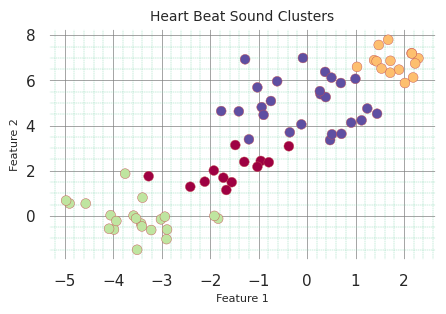

In [52]:
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=spectral_labels, cmap='Spectral', s=50,  edgecolor="r", linewidths=0.3
)
plt.title("Heart Beat Sound Clusters", fontsize=10)
plt.xlabel("Feature 1", fontsize=8)
plt.ylabel("Feature 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()